In [982]:
import pandas as pd
import category_encoders as ce
import numpy as np
import datetime
from collections import Counter
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # для разделения датасета
from sklearn import preprocessing

#для эмоциональности текста
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

# библиотеки для визуализации 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
# исходник 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# Оценки отелей на Booking

<center> <img src="https://serm-expert.ru/wp-content/uploads/2022/02/booking-1-1.jpg"> </center>

## Чтение данных 

In [983]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [984]:
# фиксируем RANDOM_SEED, для воспроизводимости эксперимента
RANDOM_SEED = 42

In [985]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [986]:
!pip freeze > requirements.txt

In [987]:
sample_submission.head(5)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [988]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_test, df_train], ignore_index=True, sort=False)

# Очистка данных

In [989]:
# считаем количество дубликатов
num_duplicates = hotels.duplicated().sum() 

# вывод количества дубликатов
print("Количество дубликатов в датасете: ", num_duplicates)


Количество дубликатов в датасете:  336


# Исследование данных

In [990]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [991]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [992]:
hotels['hotel_address'].mode() # Ищем адрес самого популярного отеля

0    163 Marsh Wall Docklands Tower Hamlets London ...
Name: hotel_address, dtype: object

In [993]:
#ищем в столбцах данные, содержащие пропущенные значения
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [994]:
#выводим имена столбцов

hotels.columns 

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score'],
      dtype='object')

## Преобразование данных и добавление новых признаков 


### Создаём признак уникальных имён 

In [995]:
hotels['unique_names'] = hotels['hotel_name'].unique().shape[0]
hotels['unique_names'] 

0         1492
1         1492
2         1492
3         1492
4         1492
          ... 
515733    1492
515734    1492
515735    1492
515736    1492
515737    1492
Name: unique_names, Length: 515738, dtype: int64

### Расстояние от каждого отеля до центра

In [996]:
# выделяем город и страну 
hotels['country'] = hotels['hotel_address'].apply(
    lambda x: x.split()[-1] 
        if x.split()[-1] != 'Kingdom'
        else ' '.join(x.split()[-2:])
)
    
hotels['city'] = hotels.apply(
    lambda x: x['hotel_address'].split()[-5] 
        if x['country'] == 'United Kingdom'
        else x['hotel_address'].split()[-2], axis=1
)
display(hotels[['country', 'city']].value_counts())

country         city     
United Kingdom  London       262301
Spain           Barcelona     60149
France          Paris         59928
Netherlands     Amsterdam     57214
Austria         Vienna        38939
Italy           Milan         37207
dtype: int64

In [997]:
population_df = pd.DataFrame(
    [
        ['London', 8.982, 51.50735, -0.12776], 
        ['Barcelona', 1.62, 41.3888, 2.15899], 
        ['Paris', 2.161, 48.85661, 2.35222], 
        ['Amsterdam', 0.822, 52.37022, 4.89517], 
        ['Vienna', 1.897, 48.20817, 16.37382], 
        ['Milan', 1.352, 45.45863, 9.18187]
    ], 
    columns=['city', 'city_population', 'center_lat', 'center_lng']
)
hotels = hotels.merge(population_df, how='left', on='city')

In [998]:
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['city'])
type_bin = type_bin.rename(columns={'city_1':'London','city_2':'Paris','city_3':'Amsterdam','city_4':'Milan','city_5':'Vienna','city_6':'Barcelona'})
hotels = pd.concat([hotels, type_bin], axis=1)

In [999]:
# соединяем название города и название отеля (когда сеть отелей представлена в разных городах)
hotels['hotel_name'] = hotels.apply(lambda i: ' '.join([i.hotel_name, i.city]), axis=1)

In [1000]:
hotels.groupby(['hotel_name', 'hotel_address'], as_index=False).count().hotel_name.value_counts()[:10]

11 Cadogan Gardens London                                1
Mercure Paris Gare De Lyon TGV Paris                     1
Mercure Paris Opera Louvre Paris                         1
Mercure Paris Opera Grands Boulevards Paris              1
Mercure Paris Opera Garnier Paris                        1
Mercure Paris Op ra Faubourg Montmartre Paris            1
Mercure Paris Notre Dame Saint Germain des Pr s Paris    1
Mercure Paris Montparnasse Raspail Paris                 1
Mercure Paris Montmartre Sacr Coeur Paris                1
Mercure Paris Gobelins Place d Italie Paris              1
Name: hotel_name, dtype: int64

In [1001]:
# определим координаты по адресу там, где они пропущены
geolocator = Nominatim(user_agent="Tester")
df_empty_lat = hotels[pd.isna(hotels['lat'])].groupby(
    ['hotel_name', 'hotel_address'],
    as_index=False
)[['lat', 'lng']].sum()
for ind, row in df_empty_lat.iterrows():
    address = row['hotel_address']
    location = geolocator.geocode(address)
    if not location:
        address_index = ' '.join(address.split()[-3:])
        location = geolocator.geocode(address_index)
    if location:
        df_empty_lat.loc[ind, 'lat'] = location.latitude
        df_empty_lat.loc[ind, 'lng'] = location.longitude

df_empty_lat.drop(['hotel_address'], axis=1, inplace=True)   
hotels = hotels.merge(df_empty_lat, how='left', on='hotel_name', suffixes=('', '_geo'))
hotels.loc[pd.isna(hotels['lat']), 'lat'] = hotels['lat_geo']
hotels.loc[pd.isna(hotels['lng']), 'lng'] = hotels['lng_geo']
hotels.drop(['lat_geo', 'lng_geo'], axis=1, inplace=True)   

In [1002]:
# вычисляем расстояние до центра города
df_hotels_grouped = hotels.groupby(['hotel_name'], as_index=False)[['lat', 'lng', 'center_lat', 'center_lng']].max()
df_hotels_grouped['center_distance'] = df_hotels_grouped.apply(lambda x: geodesic((x.lat, x.lng), (x.center_lat, x.center_lng), ellipsoid='WGS-84').km, axis=1)
df_hotels_grouped.drop(['lat', 'lng', 'center_lat', 'center_lng'], axis=1, inplace=True)
hotels = hotels.merge(df_hotels_grouped, how='left', on='hotel_name')
hotels.drop(['center_lat', 'center_lng', 'lat', 'lng'], axis=1, inplace=True)   

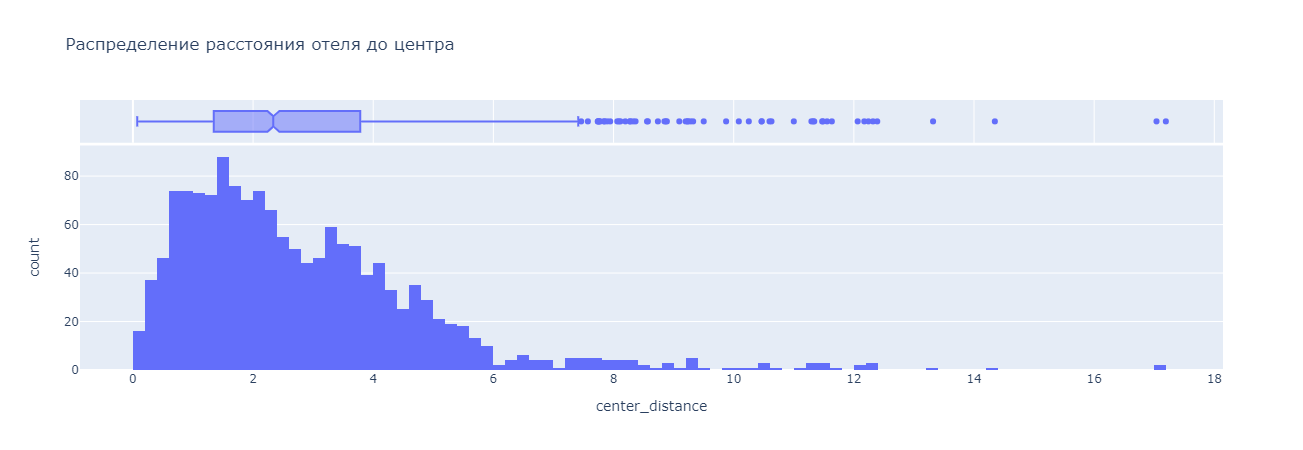

In [1003]:
# построим гистограмму распределения расстояния до центра города
fig = px.histogram(
    data_frame=hotels.groupby('hotel_name', as_index=False).center_distance.min(),
    x='center_distance',
    title='Распределение расстояния отеля до центра',
    nbins=90,
    marginal='box',
    width=1000,
)
fig.show()
#import os
#import plotly.io as pio

# Полный путь к файлу
#folder_path = 'html_plots'
#file_name = 'html_hist.html'
#file_path = os.path.join(folder_path, file_name)

# Создание папки, если она не существует
#os.makedirs(folder_path, exist_ok=True)

# Сохранение графика в HTML
#pio.write_html(fig, file_path)

### Обработка признака имени отеля

In [1004]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(hotels['hotel_name']) 
hotels = pd.concat([hotels, type_bin], axis=1)

### Обработка признака 'country'

In [1005]:
label_encoder = LabelEncoder()
hotels['country_encoded'] = label_encoder.fit_transform(hotels['country'])

# One-Hot Encoding
hotels_encoded = pd.get_dummies(hotels, columns=['country'], prefix='country')

### Популярность отеля

In [1006]:
# Создание признака "популярность отеля" на основе количества отзывов
hotels['popularity'] = hotels['total_number_of_reviews']

# Вывод результатов
print(hotels[['hotel_name', 'popularity']])

                                               hotel_name  popularity
0                                    Hotel Da Vinci Milan       16670
1                             Urban Lodge Hotel Amsterdam        5018
2       Alexandra Barcelona A DoubleTree by Hilton Bar...         351
3                          Hotel Principe Di Savoia Milan        1543
4                                Hotel Esther a Amsterdam        4687
...                                                   ...         ...
515733                             Hotel Moonlight London         617
515734               BEST WESTERN PLUS Amedia Wien Vienna        3224
515735                     Bloomsbury Palace Hotel London        2751
515736                      The Marble Arch London London        1567
515737                       The Nadler Kensington London        1209

[515738 rows x 2 columns]


### Признак категории отеля

In [1007]:
category_mapping = {'Бизнес': 1, 'Развлечения': 2, 'Общий': 3}

# Создание функции для определения категории отеля
def get_hotel_category(tags):
    if 'Business' in tags:
        return 'Бизнес'
    elif 'Leisure' in tags:
        return 'Развлечения'
    else:
        return 'Общий'

# Применение функции к столбцу 'tags' и создание нового столбца 'hotel_category'
hotels['hotel_category'] = hotels['tags'].apply(get_hotel_category).map(category_mapping)
hotels['hotel_category'].tail()






515733    2
515734    2
515735    1
515736    2
515737    2
Name: hotel_category, dtype: int64

### Обработка признака 'reviewer_nationality'

In [1008]:
# признак страны для отелей
hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' \
                                                                      else ' '.join(x.split()[-2:]))

# убераем пробелы в названии места жительства резидента
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x[1:-1])

# создадаём признак,определяющий иностранец или "местный житель  писал отзыв"
hotels['local_reviewer'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] 
                                                else 0, axis=1)

hotels['local_reviewer'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: local_reviewer, dtype: float64

In [1009]:
hotels['reviewer_nationality'].nunique(dropna=False)

227

In [1010]:
# применяем бинарное колдирование к признаку 'reviewer_nationality'
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])

hotels = pd.concat([hotels, type_bin], axis=1)

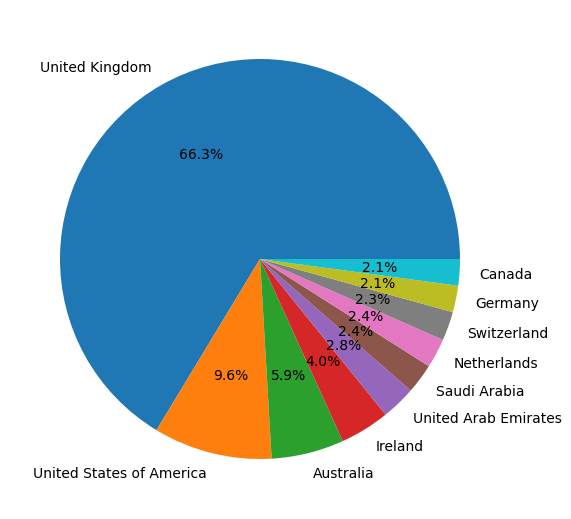

In [1011]:
reviewer_data = hotels['reviewer_nationality'].value_counts().nlargest(10)
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    reviewer_data,
    labels = reviewer_data.index,
    autopct = '%.1f%%'
);

### Отношение негативных и позитивных слов к общему количеству слов в отзыве. 

In [1012]:
# Вычисление отношения негативных и позитивных слов к общему количеству слов в отзыве
total_word_counts = hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts']
hotels['Negative_Word_Ratio'] = hotels['review_total_negative_word_counts'] / total_word_counts
hotels['Positive_Word_Ratio'] = hotels['review_total_positive_word_counts'] / total_word_counts

hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,Negative_Word_Ratio,Positive_Word_Ratio
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci Milan,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,1,0.45614,0.54386
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel Amsterdam,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,1,0,1.00000,0.00000
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton Bar...,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0,0,0,0,0,1,1,0.37500,0.62500
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia Milan,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0,0,0,0,1,0,0,0.00000,1.00000
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a Amsterdam,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0,0,0,0,0,0,1,0.00000,1.00000


### Соотношение положительных и отрицательных отзывов 

In [1013]:

# Расчет соотношения положительных и отрицательных отзывов
hotels['review_sentiment_ratio'] = hotels['review_total_positive_word_counts'] / hotels['review_total_negative_word_counts']
hotels['review_sentiment_ratio'].replace(np.inf, np.nan, inplace=True)
# Вывод результатов
display(hotels[['review_total_positive_word_counts', 'review_total_negative_word_counts', 'review_sentiment_ratio']])


,review_total_positive_word_counts,review_total_negative_word_counts,review_sentiment_ratio
0,62,52,1.192308
1,0,10,0.000000
2,5,3,1.666667
3,27,0,NaN
4,7,0,NaN
...,...,...,...
515733,10,0,NaN
515734,93,0,NaN
515735,9,12,0.750000
515736,6,0,NaN


### Анализ наличия определенных ключевых слов

In [1014]:
# Задаем список ключевых слов или фраз для анализа
keywords = ['good', 'bad', 'excellent', 'poor', 'recommend']

# Создаем новые бинарные признаки для каждого ключевого слова или фразы
for keyword in keywords:
    hotels[keyword + '_present'] = hotels['positive_review'].str.contains(keyword, case=False) | hotels['negative_review'].str.contains(keyword, case=False)

# Выводим статистику по наличию ключевых слов или фраз
for keyword in keywords:
    keyword_present_count = hotels[keyword + '_present'].sum()
    print(f"Количество отзывов с упоминанием '{keyword}': {keyword_present_count}")








Количество отзывов с упоминанием 'good': 110093
Количество отзывов с упоминанием 'bad': 12146
Количество отзывов с упоминанием 'excellent': 59965
Количество отзывов с упоминанием 'poor': 16600
Количество отзывов с упоминанием 'recommend': 14433


In [1015]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Средняя длина слова в отзыве

In [1016]:
def avg_word_length(text):
    words = text.split()
    if len(words) > 0:
        return sum(len(word) for word in words) / len(words)
    else:
        return 0  # Возвращаем 0, если список пуст

# Создаем новый столбец "avg_word_length" для отрицательных и положительных отзывов
hotels['avg_word_length_negative'] = hotels.loc[hotels['negative_review'].notnull(), 'negative_review'].apply(avg_word_length)
hotels['avg_word_length_positive'] = hotels.loc[hotels['positive_review'].notnull(), 'positive_review'].apply(avg_word_length)

# Выводим средние значения для отрицательных и положительных отзывов
print("Средняя длина слова в отрицательных отзывах:", hotels['avg_word_length_negative'].mean())
print("Средняя длина слова в положительных отзывах:", hotels['avg_word_length_positive'].mean())

Средняя длина слова в отрицательных отзывах: 4.667638229627141
Средняя длина слова в положительных отзывах: 5.1873011212212194


In [1017]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 60 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Работа с датами

In [1018]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print(f"Data_max: {hotels['review_date'].max()}")
print(f"Data_min: {hotels['review_date'].min()}")



Data_max: 2017-08-03 00:00:00
Data_min: 2015-08-04 00:00:00


In [1019]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])  # Преобразуем признак в формат даты.
hotels['review_date_month'] = pd.DatetimeIndex(hotels['review_date']).month # Оставим только месяц.
hotels['days_since_review'] = hotels['days_since_review'].str.replace('days', '').str.replace('day', '').astype('int32')
hotels = hotels.drop('review_date', axis=1) # Удалим исходный столбец.
hotels.shape

(515738, 60)

In [1020]:
# создаём новые признаки в бинарном формате

encoder = ce.BinaryEncoder(cols=['review_date_month']) # указываем столбец для кодирования.
type_bin = encoder.fit_transform(hotels['review_date_month'])
hotels = pd.concat([hotels, type_bin], axis=1).reset_index()
hotels = hotels.drop('review_date_month', axis=1)
hotels.shape

(515738, 64)

In [1021]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       515738 non-null  int64  
 1   hotel_address                               515738 non-null  object 
 2   additional_number_of_scoring                515738 non-null  int64  
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Обработка тегов 

In [1022]:
def collect_tags(df):
    # Эта функция собирает информацию о тегах по типу и количеству
    # Args:
    #    df: input data
    # Returns:
    #    tags_list (список состоящий из списков)
    #    tags_dict (словарь): словарь тегов и их количество
        
    # Создание пустого списка и словаря тегов
    tags_dict = dict()
    tags_list = list()
    
    for item, i in df['tags'].items():
        # Получаем теги из строк, заменяем всё ненужное
        tags = list(i.replace("[' ", '').replace(" ']", '').split(" ', ' "))
        # Заполняем тег лист
        tags_list.append(tags)
        for tag in tags:
            if tag not in tags_dict.keys():
                tags_dict.update({tag: 1})
            else:
                tags_dict[tag] += 1
                
    return tags_list, tags_dict

# Получаем список тегов и словарь тегов и их количество
tags_list, tags_dict = collect_tags(hotels)

# Подсчитываем количество уникальных тегов
unique_tags_count = len(tags_dict)
print("Количество уникальных тегов:", unique_tags_count)

# Создаем новый признак "количество уникальных тегов" в датафрейме hotels
hotels['unique_tags_count'] = unique_tags_count

Количество уникальных тегов: 2428


In [1023]:
tags = []
for tag_list in hotels['tags'].values:
    
    tag_list = tag_list.replace("[' ", "")
    tag_list = tag_list.replace(" ']", "")
    tag_list = tag_list.split(" ', ' ")
    tags.extend(tag_list)

# подсчитываем количество тэгов с помощью класса Counter
tag_counter = Counter(tags)
sorted_tags = list(tag_counter.most_common())
sorted_tags[:10] 

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015)]

In [1024]:
# извлекаем количество ночей
def get_stayed_nights(tags):
    tags_list = tags.split(' ')
    if 'Stayed' in tags_list:
        night_index = tags_list.index('Stayed') + 1
        return int(tags_list[night_index])
    else:
        return np.NaN

hotels['stayed_nights'] = hotels['tags'].apply(get_stayed_nights)


# дополним датасет ещё 15 колонками-индикаторами самых популярных тэгов
new_columns = []

for tag, count in sorted_tags:
    if 'Stayed' not in tag:
        new_columns.append(tag)    
        
for column in new_columns[:15]:
    hotels[column] = hotels['tags'].apply(lambda x: 1 if column in x else 0)

### Работа с колонками 'negative_review' и 'positive_review'

In [1025]:
hotels['negative_review'].head(10)

0     Would have appreciated a shop in the hotel th...
1          No tissue paper box was present at the room
2                                             Pillows 
3                                          No Negative
4                                          No Negative
5                            They don t have free wifi
6     Room generally a bit shabby with some lack of...
7     Executive rooms 9th Floor don t have a bath T...
8                      Pity about the two days of rain
9     Didn t like it at all construction was in pro...
Name: negative_review, dtype: object

In [1026]:
hotels['no_negative'] = hotels['negative_review'].apply(lambda i: 1 if i == 'No Negative' else 0)

In [1027]:
hotels['positive_review'].head(10)

0     Hotel was great clean friendly staff free bre...
1                                          No Positive
2                           Nice welcoming and service
3     Everything including the nice upgrade The Hot...
4                      Lovely hotel v welcoming staff 
5     The location is perfect if you don t have a l...
6     Location price It did not cost much more to h...
7     Comphy bed upgraded to executive room with ne...
8          Its centrality proximity to our destination
9     Didn t like anything about the stay if i had ...
Name: positive_review, dtype: object

In [1028]:
hotels['no_positive'] = hotels['positive_review'].apply(lambda i: 1 if i == 'No Positive' else 0)

In [1029]:


# из отзывов выделим эмоциональную окраску текста в отзывах
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()


# в результате обработки выдается словарь с четырьмя парами ключ:значение
# по негативным отзывам
hotels['negative_review'] = hotels['negative_review'].apply(sent_analyzer.polarity_scores)
# по позитивным отзывам
hotels['positive_review'] = hotels['positive_review'].apply(sent_analyzer.polarity_scores)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1030]:


# создадим новые признаки из негативнного отзыва
hotels['negative_neg'] = hotels['negative_review'].apply(lambda x: x['neg'])
hotels['negative_neu'] = hotels['negative_review'].apply(lambda x: x['neu'])
hotels['negative_pos'] = hotels['negative_review'].apply(lambda x: x['pos'])
hotels['negative_compound'] = hotels['negative_review'].apply(lambda x: x['compound'])

# создадим новые признаки из позитивного отзыва
hotels['positive_neg'] = hotels['positive_review'].apply(lambda x: x['neg'])
hotels['positive_neu'] = hotels['positive_review'].apply(lambda x: x['neu'])
hotels['positive_pos'] = hotels['positive_review'].apply(lambda x: x['pos'])
hotels['positive_compound'] = hotels['positive_review'].apply(lambda x: x['compound'])

In [1031]:
# удалим ненужные теперь признаки отзывов
hotels.drop(['negative_review', 'positive_review'], axis=1, inplace=True)

### Обработка пропущенных значений

In [1032]:


# Создание экземпляра SimpleImputer с выбранным методом заполнения (mean или median)
imputer = SimpleImputer(strategy='mean')  # Или strategy='median'

# Заполнение пропущенных значений в признаке 'Negative_Word_Ratio' средним значением
hotels['Negative_Word_Ratio'] = imputer.fit_transform(hotels[['Negative_Word_Ratio']])

# Заполнение пропущенных значений в признаке 'Positive_Word_Ratio' средним значением
hotels['Positive_Word_Ratio'] = imputer.fit_transform(hotels[['Positive_Word_Ratio']])

# Заполнение пропущенных значений в признаке 'review_sentiment_ratio' средним значением
hotels['review_sentiment_ratio'] = imputer.fit_transform(hotels[['review_sentiment_ratio']])

### Рассчитываем среднее количество отзывов на одного рецензента


In [1033]:
# Группировка данных по рецензенту и вычисление среднего количества отзывов
reviewer_avg_reviews = hotels.groupby('reviewer_nationality')['total_number_of_reviews_reviewer_has_given'].mean()

# Создание нового столбца 'avg_reviews_per_reviewer' и заполнение средними значениями
hotels['avg_reviews_per_reviewer'] = hotels['reviewer_nationality'].map(reviewer_avg_reviews)

# Вывод среднего значения для всего датасета
print("Среднее количество отзывов на одного рецензента:", hotels['avg_reviews_per_reviewer'].mean())

Среднее количество отзывов на одного рецензента: 7.1660009539727545


In [1034]:
hotels['avg_reviews_per_reviewer']

0          5.173299
1         12.236777
2          9.375891
3          5.212546
4          5.173299
            ...    
515733    10.756853
515734    10.472814
515735    11.931145
515736     8.539521
515737     8.467398
Name: avg_reviews_per_reviewer, Length: 515738, dtype: float64

In [1035]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 90 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       515738 non-null  int64  
 1   hotel_address                               515738 non-null  object 
 2   additional_number_of_scoring                515738 non-null  int64  
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

### Масштабирование признаков

#### Не будем делать, так как особо не улучшает MAPE 

In [1036]:




# Признаки, которые необходимо масштабировать
#features_to_scale = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews']

# Применяем стандартизацию
#scaler = StandardScaler()
#hotels_scaled_standard = hotels.copy()
#hotels_scaled_standard[features_to_scale] = scaler.fit_transform(hotels[features_to_scale])

# Применяем нормализацию
#scaler = MinMaxScaler()
#hotels_scaled_minmax = hotels.copy()
#hotels_scaled_minmax[features_to_scale] = scaler.fit_transform(hotels[features_to_scale])
#hotels_scaled_minmax[features_to_scale]


# Оценка мультиколлинеарности признаков

/tmp/ipykernel_32/141906725.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

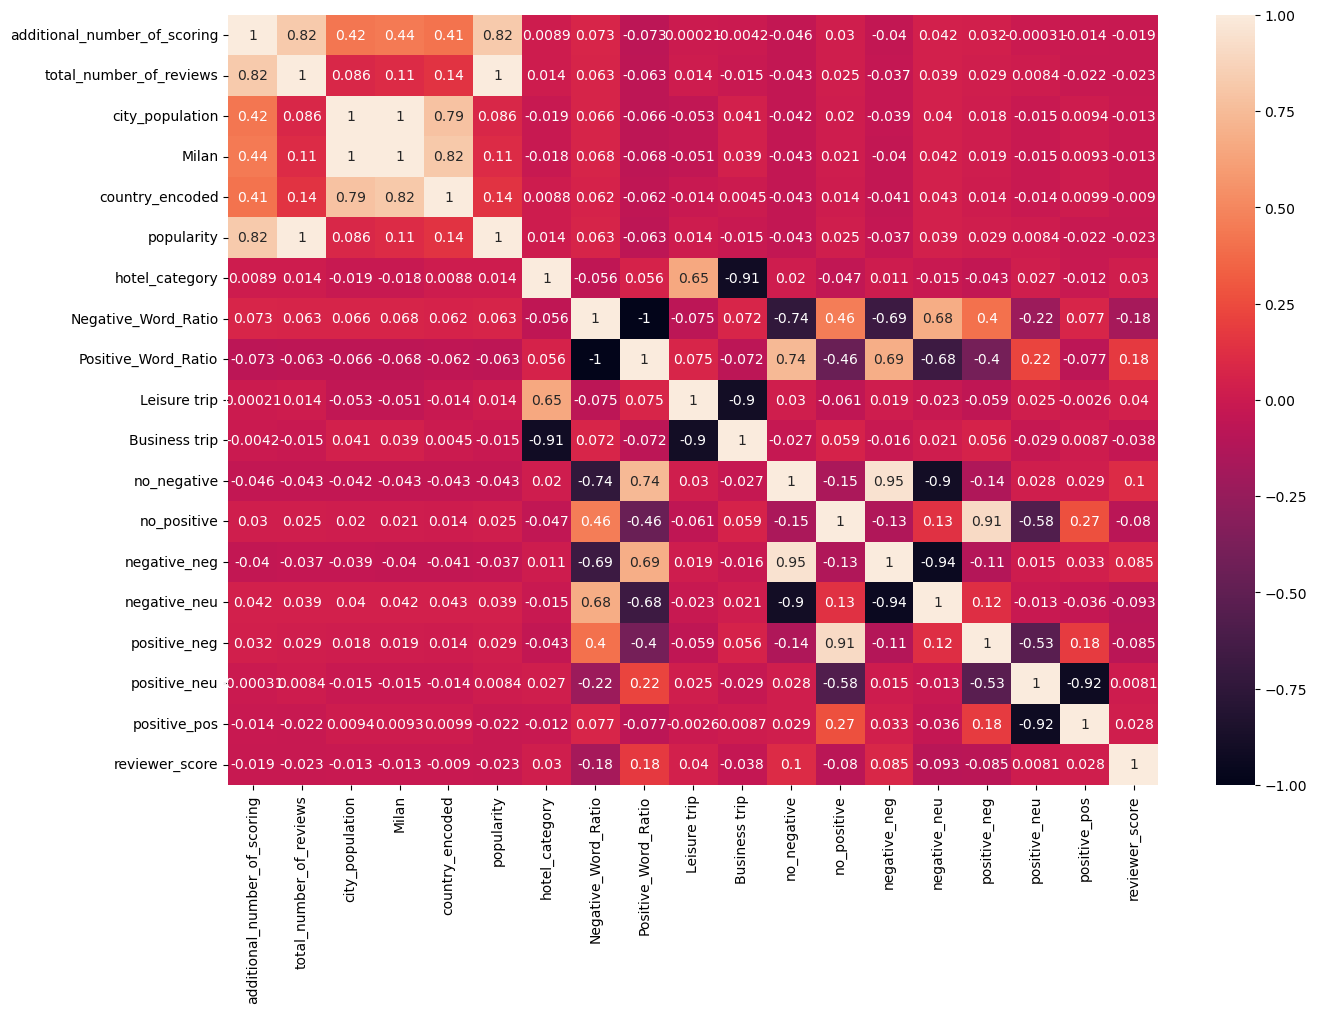

In [1037]:
df_corr = hotels.drop(['sample'], axis=1).corr()
result_columns = []
for column in df_corr:
    col_data = df_corr[column]
    if col_data.min() < -0.8 or col_data.sort_values(ascending=False)[1] > 0.8:
        result_columns.append(column)
result_columns.append('reviewer_score')
        
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels[result_columns].corr(), annot=True)

In [1038]:
# рассмотрим признаки, между которыми наблюдается сильная связь
for row in df_corr.index:
    for col in df_corr.columns:
        if df_corr.loc[row, col] != 1 and abs(df_corr.loc[row, col]) >= 0.7:
            print(row, col, '-', round(abs(df_corr.loc[row, col]), 3))

additional_number_of_scoring total_number_of_reviews - 0.825
additional_number_of_scoring popularity - 0.825
total_number_of_reviews additional_number_of_scoring - 0.825
city_population Milan - 0.996
city_population country_encoded - 0.787
Milan city_population - 0.996
Milan country_encoded - 0.82
country_encoded city_population - 0.787
country_encoded Milan - 0.82
popularity additional_number_of_scoring - 0.825
hotel_category Business trip - 0.91
Negative_Word_Ratio Positive_Word_Ratio - 1.0
Negative_Word_Ratio no_negative - 0.74
Positive_Word_Ratio Negative_Word_Ratio - 1.0
Positive_Word_Ratio no_negative - 0.74
Leisure trip Business trip - 0.904
Business trip hotel_category - 0.91
Business trip Leisure trip - 0.904
no_negative Negative_Word_Ratio - 0.74
no_negative Positive_Word_Ratio - 0.74
no_negative negative_neg - 0.949
no_negative negative_neu - 0.904
no_positive positive_neg - 0.912
negative_neg no_negative - 0.949
negative_neg negative_neu - 0.943
negative_neg negative_compou

#### Удалять признаки не будем потому что это не имеет смысла, точность от этого особо не изменяется

### Анализ выбросов 

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



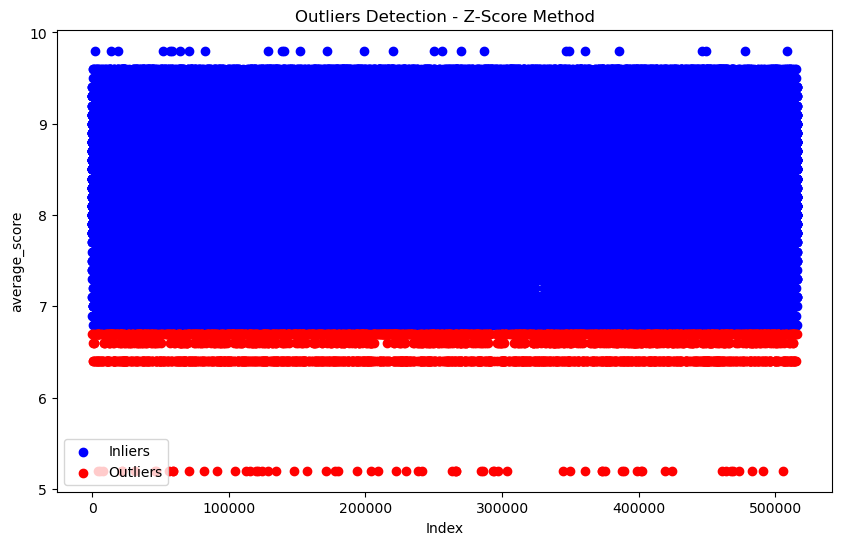

In [1039]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(hotels, feature, log_scale=False):
    if log_scale:
        x = np.log(hotels[feature]+1)
    else:
        x = hotels[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = hotels[(x < lower_bound) | (x > upper_bound)]
    cleaned = hotels[(x > lower_bound) & (x < upper_bound)]
     # Построение графика выбросов
    plt.figure(figsize=(10, 6))
    plt.scatter(cleaned.index, cleaned[feature], color='blue', label='Inliers')
    plt.scatter(outliers.index, outliers[feature], color='red', label='Outliers')
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.title('Outliers Detection - Z-Score Method')
    plt.legend()
    plt.show()
    
    return outliers, cleaned

outliers, cleaned = outliers_z_score(hotels, 'average_score')


### Удаление нечисловых признаков 

In [1040]:
# убираем признаки которые еще не успели обработать
object_columns = [i for i in hotels.columns if hotels[i].dtypes == 'object']

hotels.drop(object_columns, axis=1, inplace=True)
# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)


In [1041]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 84 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       515738 non-null  int64  
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int32  
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

### Создание и обучение регрессивной модели by RandomForestRegressor

In [1042]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1) 
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наша цель
X = train_data.drop(['reviewer_score'], axis=1)

In [1043]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1044]:
# проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 83), (386803, 83), (386803, 82), (309442, 82), (77361, 82))

In [1045]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1046]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


### Эффективность модели

In [1047]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [1048]:

   
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))



MAE: 0.8592690502966608


In [1049]:

# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', mape(y_test, y_pred))

MAPE: 12.245399283179834


### Предсказание по тестовым данным 

<Axes: >

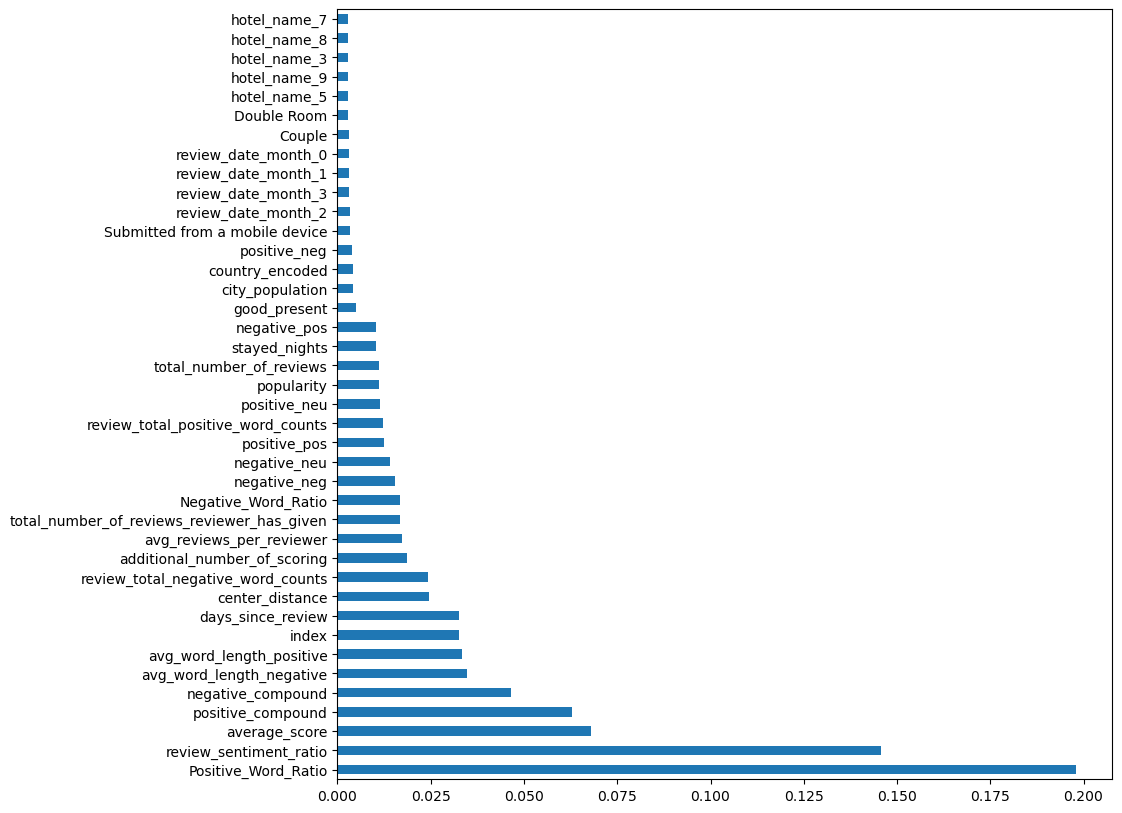

In [1050]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

In [1051]:
feat_importances.nlargest(15).index

Index(['Positive_Word_Ratio', 'review_sentiment_ratio', 'average_score',
       'positive_compound', 'negative_compound', 'avg_word_length_negative',
       'avg_word_length_positive', 'index', 'days_since_review',
       'center_distance', 'review_total_negative_word_counts',
       'additional_number_of_scoring', 'avg_reviews_per_reviewer',
       'total_number_of_reviews_reviewer_has_given', 'Negative_Word_Ratio'],
      dtype='object')

In [1052]:
test_data.sample(10)

,index,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,unique_names,...,no_positive,negative_neg,negative_neu,negative_pos,negative_compound,positive_neg,positive_neu,positive_pos,positive_compound,avg_reviews_per_reviewer
89377,89377,137,8.6,10,1179,14,2,670,0.0,1492,...,0,0.000,1.000,0.000,0.0000,0.000,0.545,0.455,0.8176,10.384209
78518,78518,2623,8.7,66,12158,20,5,576,0.0,1492,...,0,0.066,0.826,0.108,0.4215,0.000,1.000,0.000,0.0000,8.467398
68401,68401,1058,7.7,5,4380,29,1,102,0.0,1492,...,0,0.000,1.000,0.000,0.0000,0.090,0.694,0.217,0.6597,5.173299
108152,108152,995,8.1,0,3826,23,1,58,0.0,1492,...,0,1.000,0.000,0.000,-0.7096,0.000,0.569,0.431,0.9070,5.173299
68782,68782,500,9.1,7,2113,18,1,66,0.0,1492,...,0,0.000,1.000,0.000,0.0000,0.000,0.643,0.357,0.8297,6.321003
116206,116206,391,8.8,0,4887,75,11,34,0.0,1492,...,0,1.000,0.000,0.000,-0.7096,0.000,0.702,0.298,0.9738,5.173299
64660,64660,198,8.2,6,1046,0,7,334,0.0,1492,...,1,0.000,1.000,0.000,0.0000,0.379,0.000,0.621,0.3400,5.173299
5990,5990,194,7.7,0,1403,10,1,730,0.0,1492,...,0,1.000,0.000,0.000,-0.7096,0.000,0.454,0.546,0.8025,5.173299
120290,120290,404,8.9,12,2197,14,22,402,0.0,1492,...,0,0.000,1.000,0.000,0.0000,0.000,0.393,0.607,0.8955,5.173299
121449,121449,111,8.3,7,615,8,6,197,0.0,1492,...,0,0.000,1.000,0.000,0.0000,0.000,0.706,0.294,0.3612,5.173299


In [1053]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [1054]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [1055]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


In [1056]:
predict_submission

array([8.661, 7.444, 8.083, ..., 7.88 , 9.556, 6.586])

In [1057]:
list(sample_submission)

['reviewer_score', 'id']

### Подготовка сабмишена

In [1058]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.661,488440
1,7.444,274649
2,8.083,374688
3,9.698,404352
4,9.564,451596
5,8.692,302161
6,7.305,317079
7,7.428,13963
8,8.758,159785
9,7.362,195089
